In [41]:
import wandb
import matplotlib.pyplot as plt
import dice_ml
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from dice_ml.explainer_interfaces.explainer_base import UserConfigValidationException
import plotly.graph_objects as go
from datetime import timedelta
from scripts.SEP_CFE_functions import *
from slim_tsf.func._slim_TSF import SlimTimeSeriesForestClassifier
from aeon.utils.numba.stats import row_mean
import re
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import dice_ml
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import joblib
import os
from sklearn.preprocessing import MinMaxScaler
from scripts.SEP_CFE_functions import *
min_max_scaler = MinMaxScaler()
warnings.filterwarnings("ignore")

In [42]:
DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/"

In [43]:
train_df = pd.read_csv(DATA_DIR + "train_All_window_included_reduced_top20_rowmean_dataset.csv", sep=',')
test_df = pd.read_csv(DATA_DIR + "test_All_window_included_reduced_top20_rowmean_dataset.csv", sep=',')
val_df = pd.read_csv(DATA_DIR + "val_All_window_included_reduced_top20_rowmean_dataset.csv", sep=',')
combined_df = pd.read_csv(DATA_DIR + "combined_All_window_included_reduced_top20_rowmean_with_filelist.csv", sep=',')


In [44]:
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']
X_val = val_df.drop(columns=['label'])
y_val = val_df['label']


In [45]:
print(X_train.head())

   p3_flux_ic_mean_@[648:654]  p3_flux_ic_mean_@[654:660]  \
0                    0.118200                    0.118600   
1                    0.092805                    0.105052   
2                    0.095939                    0.109774   
3                    0.596300                    0.697500   
4                    0.152500                    0.221667   

   p3_flux_ic_mean_@[645:651]  p3_flux_ic_mean_@[630:660]  \
0                    0.098667                    0.141883   
1                    0.106782                    0.119661   
2                    0.089925                    0.106783   
3                    0.472100                    0.513733   
4                    0.165300                    0.213207   

   p3_flux_ic_mean_@[624:630]  p3_flux_ic_mean_@[651:657]  \
0                    0.102000                    0.121000   
1                    0.105573                    0.105052   
2                    0.121377                    0.110520   
3                    0

In [46]:

##Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6, 7, 8]
}
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define a stratified k-fold cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a scorer that focuses on the F1 score of the positive class (assumed to be label 1)
scorer = make_scorer(f1_score, pos_label=1)

# Setup GridSearchCV with the classifier, parameter grid, CV strategy, and scorer
grid_search = GridSearchCV(estimator=rf_clf,
                           param_grid=param_grid,
                           cv=cv,
                           scoring=scorer,
                           n_jobs=-1,
                           verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score from cross-validation
print("Best parameters found:", grid_search.best_params_)
print("Best F1 score (for positive class) from CV:", grid_search.best_score_)

# Retrieve the best estimator and evaluate on the test data
best_rf = grid_search.best_estimator_
Y_pred = best_rf.predict(X_train)

# Save model
joblib.dump(best_rf, '/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/RFC_model_sep_on_fixed_window_cfe.pkl')

# Output the test classification report and confusion matrix
print("\nTest Classification Report:\n", classification_report(y_train, Y_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_train, Y_pred))



Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters found: {'max_depth': 6, 'n_estimators': 50}
Best F1 score (for positive class) from CV: 0.7691367456073338

Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1296
           1       0.88      0.93      0.90       120

    accuracy                           0.98      1416
   macro avg       0.93      0.96      0.95      1416
weighted avg       0.98      0.98      0.98      1416

Test Confusion Matrix:
 [[1280   16]
 [   8  112]]


In [47]:
# best_rf = joblib.load('/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/RFC_model_sep_on_fixed_window_cfe.pkl')

In [48]:
overall_results = []
y_pred = best_rf.predict(X_train)
overall_results.append(('training set',accuracy_score(y_train, y_pred), TSS(y_train, y_pred), HSS(y_train, y_pred)))
Y_val_pred = best_rf.predict(X_val)
overall_results.append(('validation set',accuracy_score(y_val, Y_val_pred), TSS(y_val, Y_val_pred), HSS(y_val, Y_val_pred)))
Y_test_pred = best_rf.predict(X_test)
overall_results.append(('testing set',accuracy_score(y_test, Y_test_pred), TSS(y_test, Y_test_pred), HSS(y_test, Y_test_pred)))
print(pd.DataFrame(overall_results, columns=["Dataset", "accuracy", "TSS", "HSS"]))


          Dataset  accuracy       TSS       HSS
0    training set  0.983051  0.920988  0.893948
1  validation set  0.958882  0.723554  0.730056
2     testing set  0.942396  0.626088  0.626088


                       Feature  Importance
7   p3_flux_ic_mean_@[645:660]    0.183391
5   p3_flux_ic_mean_@[651:657]    0.122181
0   p3_flux_ic_mean_@[648:654]    0.114779
1   p3_flux_ic_mean_@[654:660]    0.097978
3   p3_flux_ic_mean_@[630:660]    0.071138
13  p3_flux_ic_mean_@[633:648]    0.070097
6   p3_flux_ic_mean_@[628:643]    0.046022
11  p3_flux_ic_mean_@[646:652]    0.040045
2   p3_flux_ic_mean_@[645:651]    0.040000
17  p3_flux_ic_mean_@[573:579]    0.027234
15  p3_flux_ic_mean_@[621:627]    0.023953
8   p3_flux_ic_mean_@[615:645]    0.023948
12  p3_flux_ic_mean_@[633:639]    0.021472
10  p3_flux_ic_mean_@[600:606]    0.021187
9   p3_flux_ic_mean_@[636:642]    0.021171
18  p3_flux_ic_mean_@[606:612]    0.020848
14  p3_flux_ic_mean_@[626:632]    0.016440
16  p3_flux_ic_mean_@[627:633]    0.014614
4   p3_flux_ic_mean_@[624:630]    0.013390
19  p3_flux_ic_mean_@[622:628]    0.010112


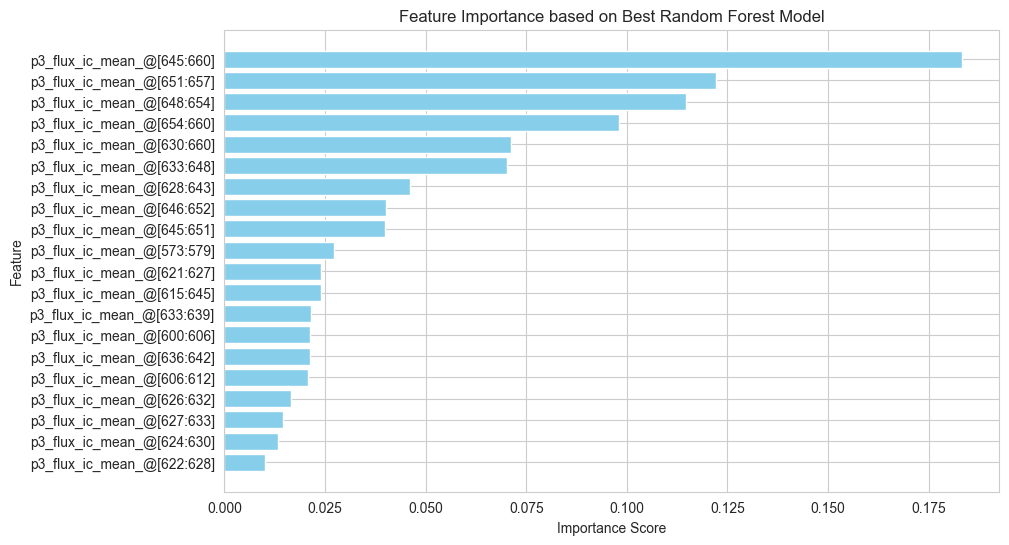

In [49]:
# Assuming `best_rf` is your trained Random Forest model
# and `X_train` contains the feature names

# Get feature importance scores
feature_importances = best_rf.feature_importances_

# Create a DataFrame to organize feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Display the top features
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance based on Best Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


In [50]:
# df_cfe = combined_df.drop(columns=['File']).copy()
df_cfe = test_df.copy()
#df_cfe = df_combined_labels.drop(["Label","File","Label.1"],axis=1)  # should contain the target column
cont_features = list(test_df.drop(["label"],axis=1).columns) #should not contain target column
data= dice_ml.Data(dataframe=df_cfe, continuous_features=cont_features, outcome_name='label')  #####use this one data is coming from test df
# data= dice_ml.Data(dataframe=df_cfe, continuous_features=cont_features, outcome_name='Label')####use this one data is coming from combined df with file list

In [51]:
#Define a Model object using dice_ml.Model (we are using this CFE model for regressor type of prediction model
cfe_model = dice_ml.Model(model=best_rf, backend="sklearn", model_type='classifier')
#Create the Dice explainer
exp_random = dice_ml.Dice(data_interface=data, model_interface=cfe_model, method="random") #method= ["genetic","kdtree","random"]

# Save the explainer (DiCE model) using joblib
joblib.dump(exp_random, "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/sep_cfe_slim_tsf_random_explainer_fixed_window.pkl")

#use `exp` to generate counterfactual explanations
print("\nRandom Dice explainer created successfully.\n")


Random Dice explainer created successfully.



In [52]:
#Define a Model object using dice_ml.Model (we are using this CFE model for regressor type of prediction model
cfe_model = dice_ml.Model(model=best_rf, backend="sklearn", model_type='classifier')
#Create the Dice explainer
exp_genetic = dice_ml.Dice(data_interface=data, model_interface=cfe_model, method="genetic") #method= ["genetic","kdtree","random"]

# Save the explainer (DiCE model) using joblib
joblib.dump(exp_genetic, "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/sep_cfe_slim_tsf_genetic_explainer_fixed_window.pkl")

#use `exp` to generate counterfactual explanations
print("\nGenetic Dice explainer created successfully.\n")


Genetic Dice explainer created successfully.



In [53]:
# exp_random = joblib.load("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/sep_cfe_slim_tsf_random_explainer_fixed_window.pkl")
# exp_genetic = joblib.load("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/sep_cfe_slim_tsf_genetic_explainer_fixed_window.pkl")

In [54]:
p3_flux_cols = [col for col in train_df.columns if 'p3_flux_ic_mean' in col]
p5_flux_cols = [col for col in train_df.columns if 'p5_flux_ic_mean' in col]
p7_flux_cols = [col for col in train_df.columns if 'p7_flux_ic_mean' in col]
long_cols = [col for col in train_df.columns if 'long_mean' in col]

In [55]:
def process_header_list(header_list):
    """
    Extracts metric intervals from header names like:
        p3_flux_ic_mean_@[300:660]
    Returns list of tuples: (metric, slice_str, start, end)
    """
    pattern = r'^(p3_flux_ic_mean|p5_flux_ic_mean|p7_flux_ic_mean|long_mean)_@\[(\d+):(\d+)\]$'
    result = []
    for col in header_list:
        m = re.match(pattern, col)
        if m:
            metric = m.group(1)
            start, end = int(m.group(2)), int(m.group(3))
            slice_str = f"{start}:{end}"
            result.append((metric, slice_str, start, end))
    return result


def build_interval_dataframe(header_list):
    """
    Builds a long-format DataFrame from a list of header names.

    Output columns:
        metric | slice | start | end
    """
    entries = process_header_list(header_list)
    df = pd.DataFrame(entries, columns=["metric", "slice", "start", "end"])
    df.sort_values(["metric", "start", "end"], inplace=True)
    return df




# ==============================
# 🚀 Example Usage
# ==============================
header_list = train_df.columns.astype(str).str.cat(sep="\t").split()
print(header_list)

df_slices = build_interval_dataframe(header_list)
print("Interval dataframe:\n", df_slices)

all_slices = list(zip(df_slices["start"], df_slices["end"]))
print("All slices:\n", all_slices)

['p3_flux_ic_mean_@[648:654]', 'p3_flux_ic_mean_@[654:660]', 'p3_flux_ic_mean_@[645:651]', 'p3_flux_ic_mean_@[630:660]', 'p3_flux_ic_mean_@[624:630]', 'p3_flux_ic_mean_@[651:657]', 'p3_flux_ic_mean_@[628:643]', 'p3_flux_ic_mean_@[645:660]', 'p3_flux_ic_mean_@[615:645]', 'p3_flux_ic_mean_@[636:642]', 'p3_flux_ic_mean_@[600:606]', 'p3_flux_ic_mean_@[646:652]', 'p3_flux_ic_mean_@[633:639]', 'p3_flux_ic_mean_@[633:648]', 'p3_flux_ic_mean_@[626:632]', 'p3_flux_ic_mean_@[621:627]', 'p3_flux_ic_mean_@[627:633]', 'p3_flux_ic_mean_@[573:579]', 'p3_flux_ic_mean_@[606:612]', 'p3_flux_ic_mean_@[622:628]', 'label']
Interval dataframe:
              metric    slice  start  end
17  p3_flux_ic_mean  573:579    573  579
10  p3_flux_ic_mean  600:606    600  606
18  p3_flux_ic_mean  606:612    606  612
8   p3_flux_ic_mean  615:645    615  645
15  p3_flux_ic_mean  621:627    621  627
19  p3_flux_ic_mean  622:628    622  628
4   p3_flux_ic_mean  624:630    624  630
14  p3_flux_ic_mean  626:632    626  632


In [56]:
len(all_slices)

20

In [57]:
def get_query_instance(query_ts_filename, df_combined_labels, model):
    """
    Retrieve the query instance and its target label for a given filename.

    Args:
           query_ts_filename (str): The filename identifying the query instance.
           df_combined_labels (pd.DataFrame): DataFrame containing labeled data.
           model: A trained classifier with a `.predict()` method.

    Returns:
        Tuple[pd.DataFrame, Any]: The query instance (features only) and its true label.
     """
    query_instance_raw = df_combined_labels[df_combined_labels['File'] == query_ts_filename]
    query_instance = query_instance_raw.drop(["Label","File"], axis=1)

    true_label = query_instance_raw["Label"].values[0]
    predicted_label = model.predict(query_instance)

    print("Target value for the query instance:\n", true_label)
    print("Predicted value:\n", predicted_label)

    return query_instance, true_label, predicted_label

In [58]:
# def get_pertubed_series(csv_path, sample_cfe, flux_type, slices, start_offset_min=300, end_offset_min=660):
#     """
#     Dynamically perturbs a flux time series using counterfactual mean adjustments.
#     Handles both pd.Series and pd.DataFrame for sample_cfe.
#     """
#     df = pd.read_csv(csv_path, delimiter=',')
#     df = df.rename(columns={'time_tag': 'time_stamp'})
#     df['time_stamp'] = pd.to_datetime(df['time_stamp'], errors='coerce')
#
#     # Subset to event window
#     event_start = df['time_stamp'].iloc[0] + timedelta(minutes=start_offset_min)
#     event_end   = df['time_stamp'].iloc[0] + timedelta(minutes=end_offset_min)
#     df_obs = df[(df['time_stamp'] >= event_start) & (df['time_stamp'] < event_end)].copy()
#     # print(f"Observations in event window: {df_obs}")
#     df_obs['minutes'] = (df_obs['time_stamp'] - event_start).dt.total_seconds() / 60
#
#     offset_accum = np.zeros_like(df_obs['minutes'], dtype=float)
#     offset_count = np.zeros_like(df_obs['minutes'], dtype=int)
#
#     # Handle Series or DataFrame case for sample_cfe
#     if isinstance(sample_cfe, pd.DataFrame):
#         sample_cfe = sample_cfe.iloc[0]
#
#     for start_min, end_min in slices:
#         mask = (df_obs['minutes'] >= start_min) & (df_obs['minutes'] < end_min)
#         if not np.any(mask):
#             continue
#
#         pattern = f"^{flux_type}_mean_@\\[{start_min}:{end_min}\\]$"
#         matched_cols = sample_cfe.filter(regex=pattern)
#
#         if matched_cols.empty:
#             # print(f"[WARN] Missing slice for {pattern}")
#             continue
#
#         # Extract single value safely
#         if isinstance(matched_cols, pd.Series):
#             cfe_value = matched_cols.iloc[0]
#         else:
#             cfe_value = matched_cols.iloc[0, 0]
#
#         flux_data = df_obs.loc[mask, flux_type].values
#         print(f"Flux data for slice {start_min}-{end_min} mins: {flux_data}")
#         global_adjustment = cfe_value - flux_data.mean()
#         adjusted = flux_data + global_adjustment
#
#         offset_accum[mask] += adjusted
#         offset_count[mask] += 1
#
#     # Compute average adjustments
#     final_offset = np.zeros_like(df_obs['minutes'], dtype=float)
#     nonzero = offset_count > 0
#     final_offset[nonzero] = offset_accum[nonzero] / offset_count[nonzero]
#
#     # Build final series
#     original = df_obs[flux_type].values
#     final_series = original + final_offset
#
#     return (
#         df_obs,
#         pd.Series(final_series, index=df_obs.index),
#         pd.Series(original, index=df_obs.index),
#         float(min(final_series.min(), original.min())),
#         float(max(final_series.max(), original.max())),
#     )


In [59]:
def get_pertubed_series(
    csv_path,
    sample_cfe,
    flux_type,
    header_list,
    start_offset_min=300,
    end_offset_min=660,
):
    """
    Perturb flux series based only on intervals that appear in header_list,
    matching pattern:  f"{flux_type}_mean_@[start:end]".

    Uses SAME overlapping-average-adjustment logic as your original implementation.
    """

    # -------------------------
    # Load CSV and slice window
    # -------------------------
    df = pd.read_csv(csv_path, delimiter=",")
    df = df.rename(columns={"time_tag": "time_stamp"})
    df["time_stamp"] = pd.to_datetime(df["time_stamp"], errors="coerce")

    event_start = df["time_stamp"].iloc[0] + timedelta(minutes=start_offset_min)
    event_end   = df["time_stamp"].iloc[0] + timedelta(minutes=end_offset_min)

    df_obs = df[(df["time_stamp"] >= event_start) &
                (df["time_stamp"] < event_end)].copy()

    df_obs["minutes"] = (df_obs["time_stamp"] - event_start).dt.total_seconds() / 60

    # Prepare accumulators
    offset_accum = np.zeros(len(df_obs), dtype=float)
    offset_count = np.zeros(len(df_obs), dtype=int)

    # sample_cfe row
    if isinstance(sample_cfe, pd.DataFrame):
        sample_cfe = sample_cfe.iloc[0]

    # -------------------------------------------------------------
    # Extract only the slices that match THIS flux_type
    # Pattern example: p3_flux_ic_mean_@[420:660]
    # -------------------------------------------------------------
    pattern = re.compile(rf"^{flux_type}_mean_@\[(\d+):(\d+)\]$")

    relevant_intervals = []

    for col in header_list:
        m = pattern.match(col)
        if m:
            abs_start = int(m.group(1))
            abs_end   = int(m.group(2))
            relevant_intervals.append((abs_start, abs_end))

    # ------------------------------------------
    # Apply adjustments for each matched interval
    # ------------------------------------------
    for abs_start, abs_end in relevant_intervals:

        # convert absolute → local window minutes
        local_start = abs_start - start_offset_min
        local_end   = abs_end   - start_offset_min

        mask = (df_obs["minutes"] >= local_start) & (df_obs["minutes"] < local_end)
        if not np.any(mask):
            continue

        col_name = f"{flux_type}_mean_@[{abs_start}:{abs_end}]"

        if col_name not in sample_cfe.index:
            continue  # skip missing in CFE

        cfe_value = sample_cfe[col_name]

        flux_data = df_obs.loc[mask, flux_type].values
        old_mean = flux_data.mean()
        # print(f"Flux data for {flux_type} for slice {local_start}-{local_end} mins: {flux_data}, old_mean: {old_mean}, cfe_value: {cfe_value}")
        # shift entire window to correct mean
        global_adjustment = cfe_value - old_mean
        adjusted = flux_data + global_adjustment

        # accumulate for overlapping windows
        offset_accum[mask] += adjusted
        offset_count[mask] += 1

    # -----------------------
    # Build final perturbed y
    # -----------------------
    final_offset = np.zeros(len(df_obs), dtype=float)
    nz = offset_count > 0
    final_offset[nz] = offset_accum[nz] / offset_count[nz]

    original = df_obs[flux_type].to_numpy()
    final_series = original + final_offset

    return (
        df_obs,
        pd.Series(final_series, index=df_obs.index),
        pd.Series(original, index=df_obs.index),
        float(min(final_series.min(), original.min())),
        float(max(final_series.max(), original.max())),
    )


In [60]:
# query_ts_filename = '2003-06-18_12-15.csv'
# query_instance1, class_label, predicted_label = get_query_instance(query_ts_filename, combined_df, best_rf)
#
# cfe_label = 0 if predicted_label[0] == 1 else 1
#
# print(f"cfe_label: {cfe_label}")
# cfe_exp = []
# df_cfe_exp_genetic_1 = pd.DataFrame()
# cfe_genetic = exp_genetic.generate_counterfactuals(
#     query_instance1,  #multiple query instances can be provided as an input dataframe
#     total_CFs=1,  # Number of counterfactual examples to generate
#     desired_class=cfe_label,  #'opposite' #,  # Specify the desired class for a continuous target variable
#     #permitted_range={'variable1': [20, 30], 'variable2': ['val1', 'val2']}
#     # features_to_vary=top_k_features,
#     # proximity_weight=pw,
#     # diversity_weight=dw
#     # feature_weights=sorted_normalized_weights_dict
# )
#
# cfe_genetic.visualize_as_dataframe(show_only_changes=True)
# df_cfe_exp_genetic_1 = cfe_genetic.cf_examples_list[0].final_cfs_df


In [61]:
# window_size = 10
# CSV_DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/data/"
# csv_path = os.path.join(CSV_DATA_DIR, query_ts_filename)
#
# fig, ax = plt.subplots(figsize=(20, 6), facecolor="white")
#
# # choose the CFE to display; loop if you like, or just pick one
# cfe_idx = 0
# sample_cfe = df_cfe_exp_genetic_1.iloc[cfe_idx]
#
# # p3
# flux_type = "p3_flux_ic"
# df_obs, final_series_p3, original_p3, min_y_p3, max_y_p3 = get_pertubed_series(
#     csv_path, sample_cfe, flux_type, header_list, 300, 660
# )
# orig_p3 = original_p3.rolling(window=window_size, center=True).mean()
# cf_p3 = pd.Series(final_series_p3).rolling(window=window_size, center=True).mean()
#
# # p5
# flux_type = "p5_flux_ic"
# df_obs1, final_series_p5, original_p5, min_y_p5, max_y_p5 = get_pertubed_series(
#     csv_path, sample_cfe, flux_type, header_list, 300, 660
# )
# orig_p5 = original_p5.rolling(window=window_size, center=True).mean()
# cf_p5 = pd.Series(final_series_p5).rolling(window=window_size, center=True).mean()
#
# # p7
# flux_type = "p7_flux_ic"
# df_obs2, final_series_p7, original_p7, min_y_p7, max_y_p7 = get_pertubed_series(
#     csv_path, sample_cfe, flux_type, header_list, 300, 660
# )
# orig_p7 = original_p7.rolling(window=window_size, center=True).mean()
# cf_p7 = pd.Series(final_series_p7).rolling(window=window_size, center=True).mean()
#
# # long mean
# flux_type = "long"
# df_obs3, final_series_long, original_long, min_y_l, max_y_l = get_pertubed_series(
#     csv_path, sample_cfe, flux_type, header_list, 300, 660
# )
# orig_l = original_long.rolling(window=window_size, center=True).mean()
# cf_l = pd.Series(final_series_long).rolling(window=window_size, center=True).mean()
#
# # combine limits
# ymin = min(min_y_p3, min_y_p5, min_y_p7, min_y_l)
# ymax = max(max_y_p3, max_y_p5, max_y_p7, max_y_l)
#
# # single axis plotting
# ax.set_facecolor("white")
# ax.plot(df_obs["time_stamp"], orig_p3, label="Orig p3_flux_ic", color="#FF0000")
# ax.plot(df_obs["time_stamp"], cf_p3, label="CFE p3_flux_ic", color="#FF0000", ls="--")
# ax.plot(df_obs1["time_stamp"], orig_p5, label="Orig p5_flux_ic", color="#1b5c0c")
# ax.plot(df_obs1["time_stamp"], cf_p5, label="CFE p5_flux_ic", color="#1b5c0c", ls="--")
# ax.plot(df_obs2["time_stamp"], orig_p7, label="Orig p7_flux_ic", color="#FFA500")
# ax.plot(df_obs2["time_stamp"], cf_p7, label="CFE p7_flux_ic", color="#FFA500", ls="--")
# ax.plot(df_obs3["time_stamp"], orig_l, label="Orig long X-ray", color="#1f77b4")
# ax.plot(df_obs3["time_stamp"], cf_l, label="CFE long X-ray", color="#1f77b4", ls="--")
#
# ax.set_yscale("log")
# ax.set_ylim(ymin * 0.9, ymax * 1.1)
# ax.set_xlabel("Period of Observation", fontsize=10)
# ax.set_ylabel("Particle Flux Unit (log scale)", fontsize=10)
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
# plt.setp(ax.get_xticklabels(), rotation=10, ha="center", fontsize=9)
# plt.setp(ax.get_yticklabels(), fontsize=9)
# label_str = "SEP-Event" if class_label == 1 else "Non-SEP event"
# ax.set_title(f"CFE for {label_str} (Sample #{cfe_idx+1})", fontsize=11)
# ax.legend(
#     loc="center left",         # position anchor (relative to axes)
#     bbox_to_anchor=(1.02, 0.5),# shift legend box outside the right edge
#     ncol=2,                    # 2-column layout
#     frameon=True,
#     fontsize=9
# )
#
# plt.tight_layout(rect=[0, 0, 0.85, 1])  # make room on the right side
# plt.show()
#


##2017-09-09_21-04.csv

In [62]:
# List of files you want to process
query_files = [
    '2017-10-20_22-10.csv',
    '2017-09-09_21-04.csv',
    '2015-06-12_22-32.csv',
    '2005-01-19_18-40.csv',
    '2003-05-30_16-25.csv',
    '2004-09-19_07-25.csv',
    '2003-11-20_18-08.csv'


]

# Empty list to collect CF results for all files
all_cfe_results = []

for qfile in query_files:
    print(f"\n🔹 Processing {qfile} ...")

    # 1. Get the query instance and prediction
    query_instance, class_label, predicted_label = get_query_instance(qfile, combined_df, best_rf)

    # 2. Define target counterfactual label (opposite of predicted)
    cfe_label = 0 if predicted_label[0] == 1 else 1
    print(f"   Predicted: {predicted_label[0]}, Target CF label: {cfe_label}")

    # 3. Generate counterfactual explanation
    cfe_genetic = exp_genetic.generate_counterfactuals(
        query_instance,
        total_CFs=1,                    # Number of CFs to generate per instance
        desired_class=cfe_label,        # Target label
        # permitted_range=...,           # Optional
        # features_to_vary=top_k_features,  # Optional
    )

    # 4. Extract CF dataframe
    df_cfe = cfe_genetic.cf_examples_list[0].final_cfs_df
    df_cfe["file"] = qfile
    df_cfe["original_label"] = predicted_label[0]
    df_cfe["target_label"] = cfe_label

    # 5. Append to list
    all_cfe_results.append(df_cfe)

# 6. Combine all CFs into one dataframe
df_cfe_all = pd.concat(all_cfe_results, ignore_index=True)
print("\n✅ Generated counterfactuals for all files!")
print(df_cfe_all.head())

# 7. Optionally, save to disk
output_path = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/all_cf_results.csv"
df_cfe_all.to_csv(output_path, index=False)
print(f"💾 Saved all counterfactual results to {output_path}")



🔹 Processing 2017-10-20_22-10.csv ...
Target value for the query instance:
 0
Predicted value:
 [0]
   Predicted: 0, Target CF label: 1


100%|██████████| 1/1 [00:00<00:00, 22.52it/s]



🔹 Processing 2017-09-09_21-04.csv ...
Target value for the query instance:
 0
Predicted value:
 [0]
   Predicted: 0, Target CF label: 1


100%|██████████| 1/1 [00:00<00:00, 21.92it/s]



🔹 Processing 2015-06-12_22-32.csv ...
Target value for the query instance:
 0
Predicted value:
 [0]
   Predicted: 0, Target CF label: 1


100%|██████████| 1/1 [00:00<00:00, 23.63it/s]



🔹 Processing 2005-01-19_18-40.csv ...
Target value for the query instance:
 1
Predicted value:
 [1]
   Predicted: 1, Target CF label: 0


100%|██████████| 1/1 [00:00<00:00, 22.96it/s]



🔹 Processing 2003-05-30_16-25.csv ...
Target value for the query instance:
 1
Predicted value:
 [1]
   Predicted: 1, Target CF label: 0


100%|██████████| 1/1 [00:00<00:00, 23.11it/s]



🔹 Processing 2004-09-19_07-25.csv ...
Target value for the query instance:
 1
Predicted value:
 [1]
   Predicted: 1, Target CF label: 0


100%|██████████| 1/1 [00:00<00:00, 23.53it/s]



🔹 Processing 2003-11-20_18-08.csv ...
Target value for the query instance:
 0
Predicted value:
 [0]
   Predicted: 0, Target CF label: 1


100%|██████████| 1/1 [00:00<00:00, 23.48it/s]


✅ Generated counterfactuals for all files!
   p3_flux_ic_mean_@[648:654]  p3_flux_ic_mean_@[654:660]  \
0                       0.411                      0.5929   
1                       0.411                      0.5929   
2                       0.411                      0.5929   
3                       0.869                      1.1686   
4                       0.997                      1.1774   

   p3_flux_ic_mean_@[645:651]  p3_flux_ic_mean_@[630:660]  \
0                       0.276                      0.3073   
1                       0.276                      0.3073   
2                       0.276                      0.3073   
3                       0.711                      1.0824   
4                       0.879                      0.9318   

   p3_flux_ic_mean_@[624:630]  p3_flux_ic_mean_@[651:657]  \
0                     0.13638                    0.508900   
1                     0.13638                    0.508900   
2                     0.13638          


🔹 Processing CFEs for: 2017-10-20_22-10.csv


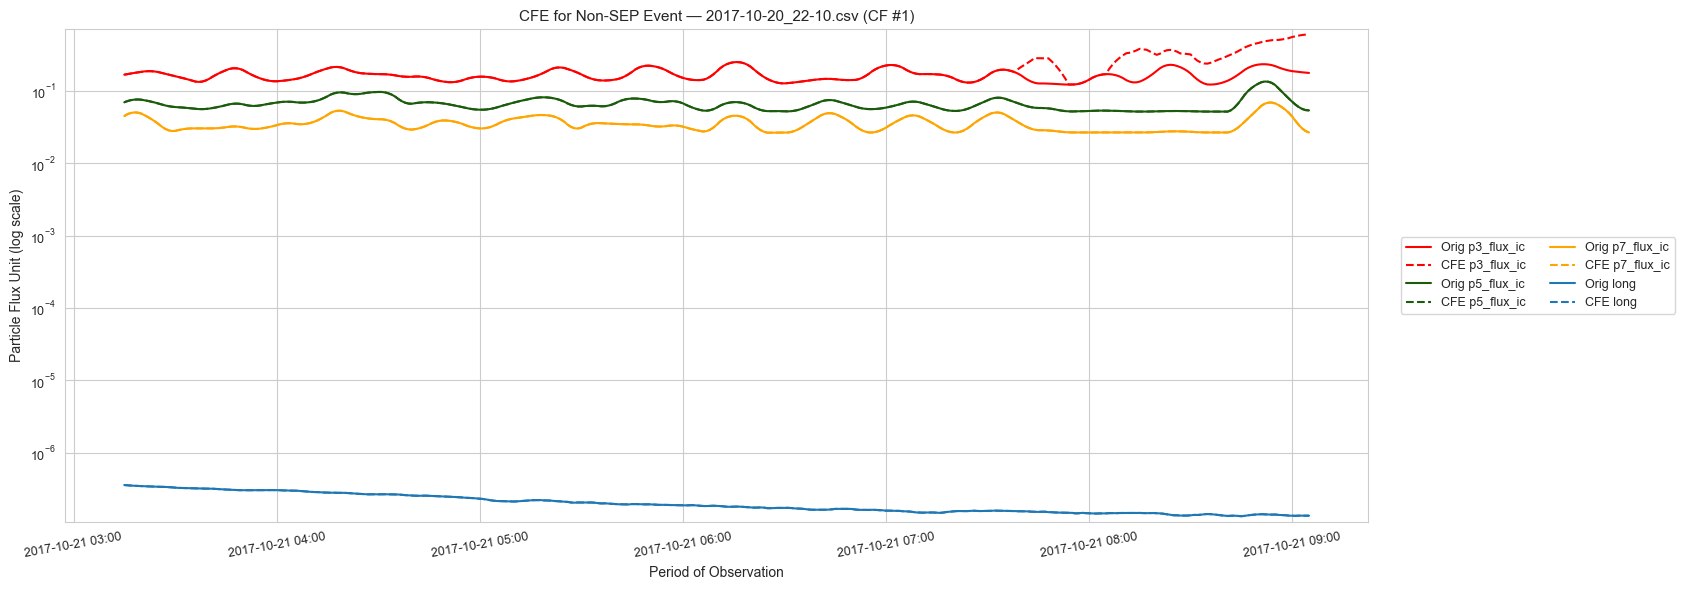

   💾 Saved: /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_visuals/CFE_2017-10-20_22-10_1.png

🔹 Processing CFEs for: 2017-09-09_21-04.csv


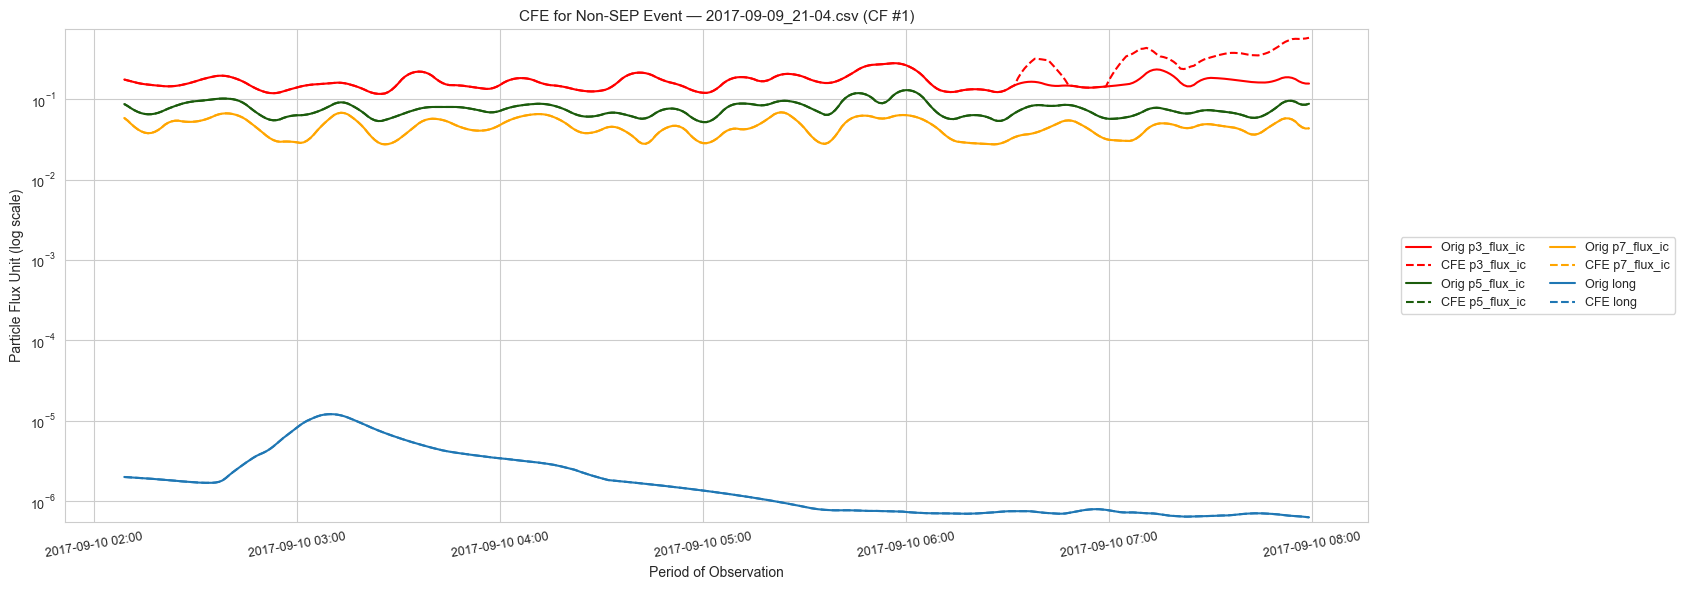

   💾 Saved: /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_visuals/CFE_2017-09-09_21-04_1.png

🔹 Processing CFEs for: 2015-06-12_22-32.csv


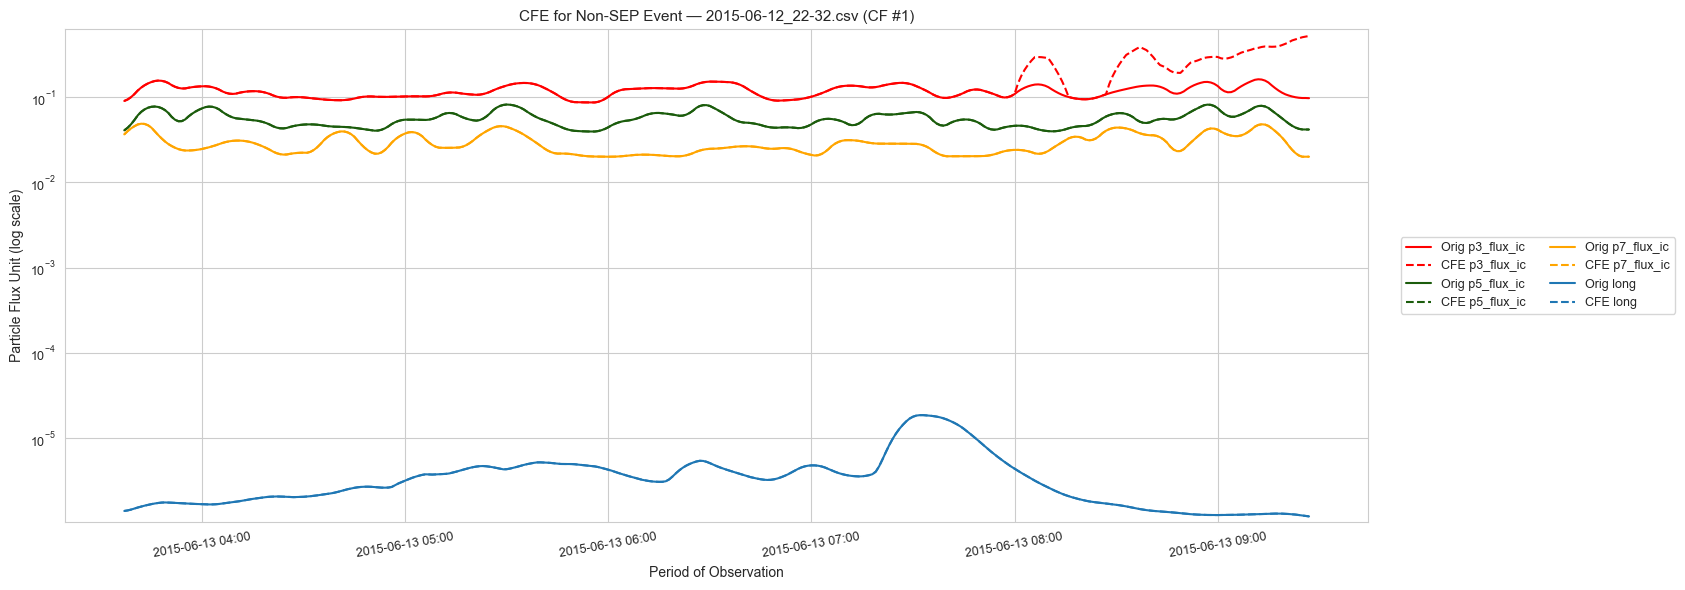

   💾 Saved: /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_visuals/CFE_2015-06-12_22-32_1.png

🔹 Processing CFEs for: 2005-01-19_18-40.csv


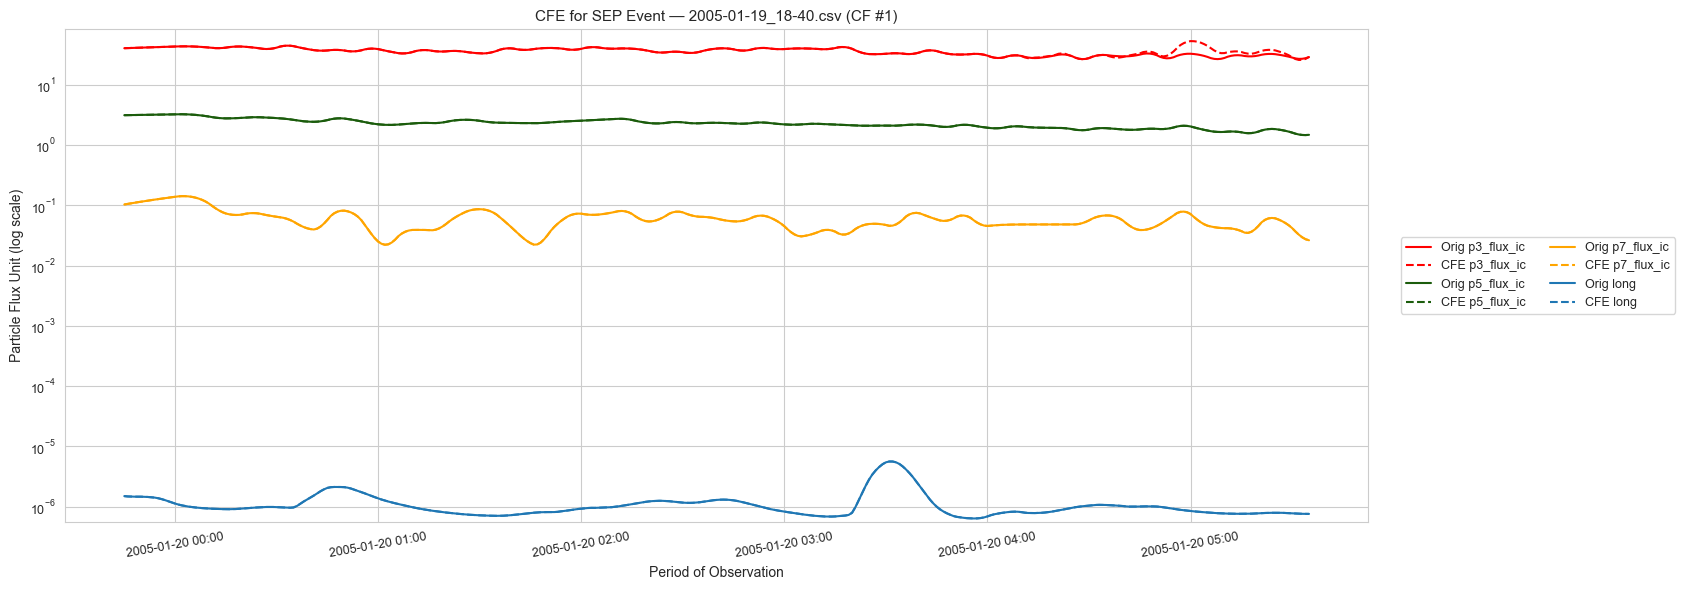

   💾 Saved: /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_visuals/CFE_2005-01-19_18-40_1.png

🔹 Processing CFEs for: 2003-05-30_16-25.csv


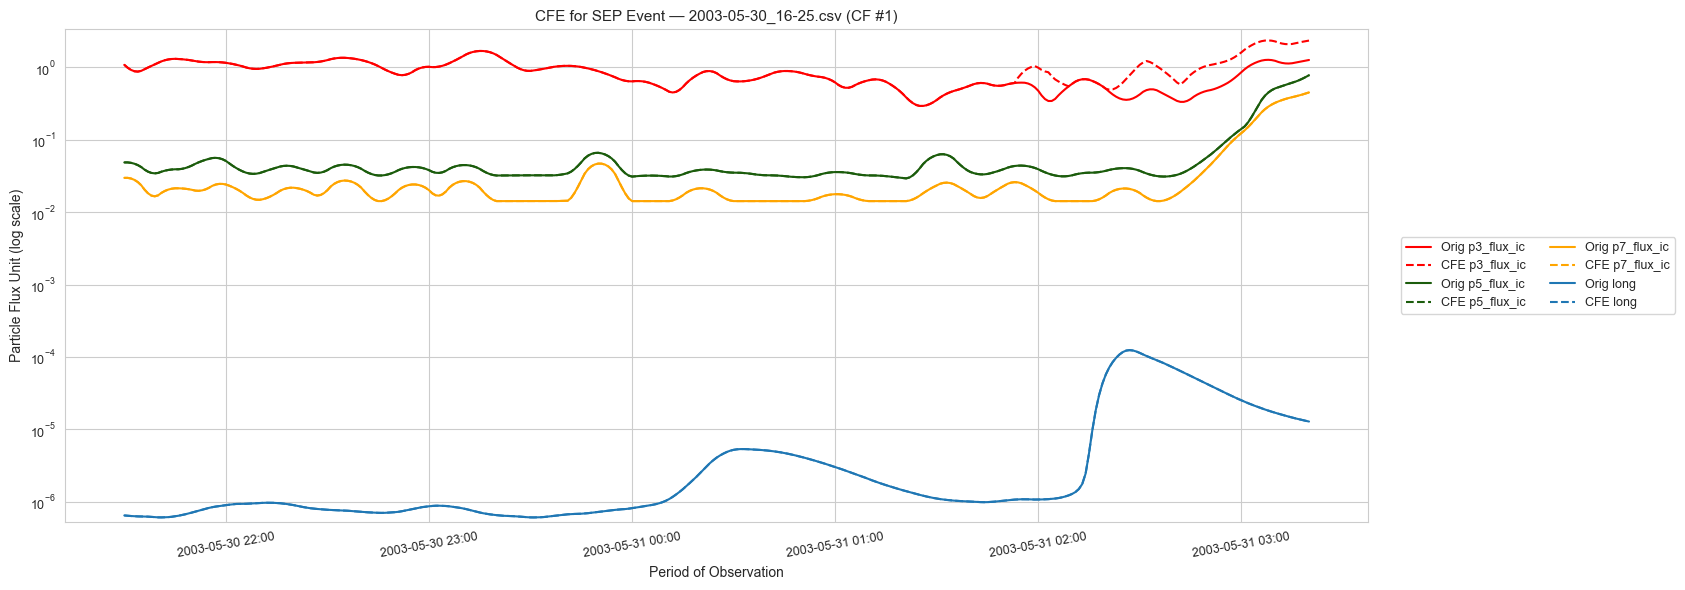

   💾 Saved: /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_visuals/CFE_2003-05-30_16-25_1.png

🔹 Processing CFEs for: 2004-09-19_07-25.csv


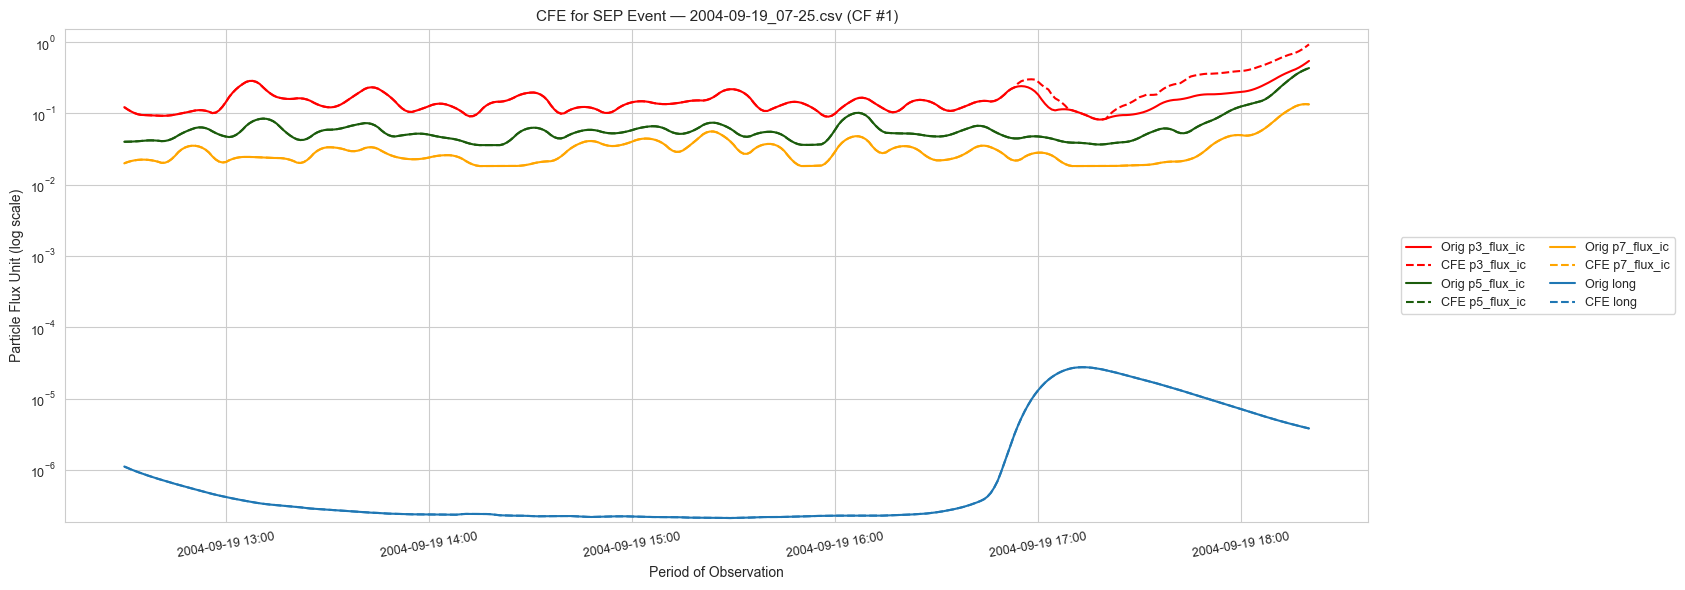

   💾 Saved: /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_visuals/CFE_2004-09-19_07-25_1.png

🔹 Processing CFEs for: 2003-11-20_18-08.csv


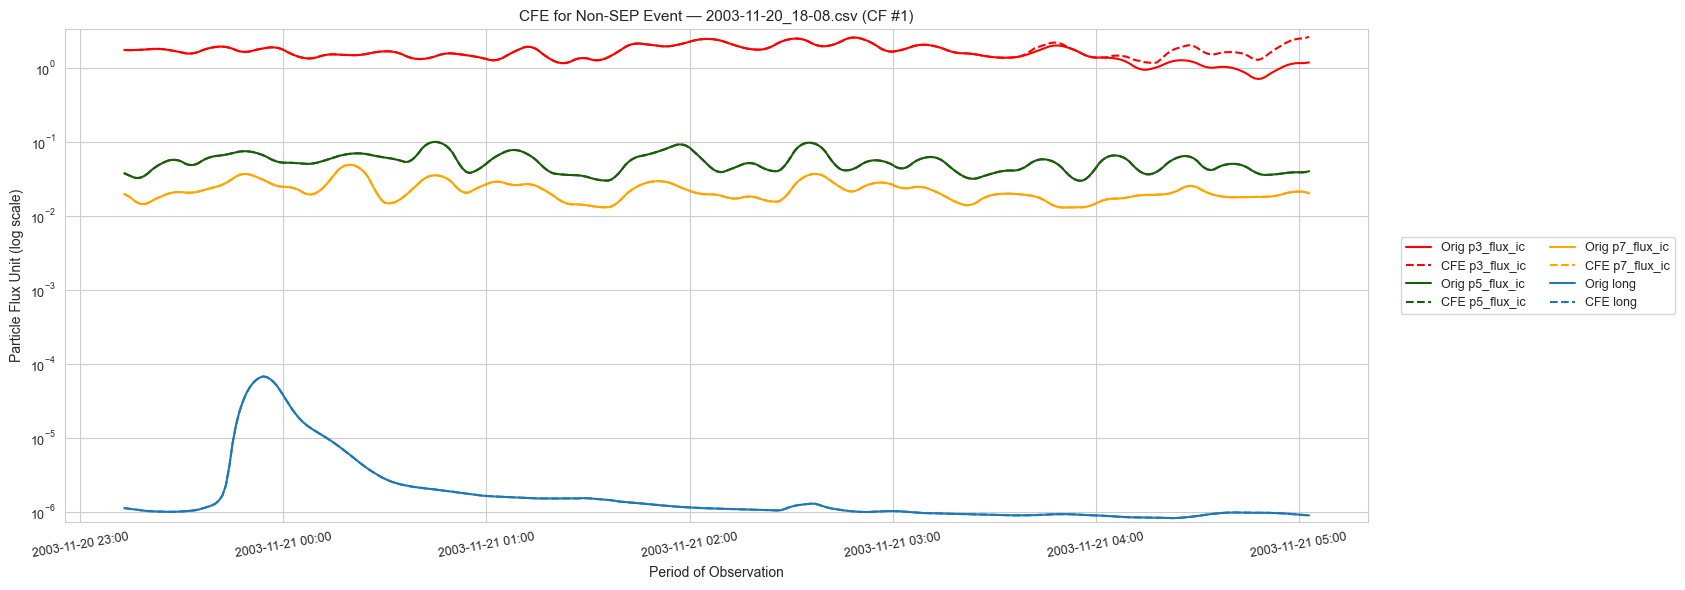

   💾 Saved: /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_visuals/CFE_2003-11-20_18-08_1.png


In [63]:
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Base data directory
CSV_DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/data/"
SAVE_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/plots/cfe_visuals"
os.makedirs(SAVE_DIR, exist_ok=True)

# Smoothing parameter
window_size = 10

# List of channels and plotting colors
channels = [
    ("p3_flux_ic", "#FF0000"),
    ("p5_flux_ic", "#1b5c0c"),
    ("p7_flux_ic", "#FFA500"),
    ("long", "#1f77b4"),
]

# Loop through all unique files in df_cfe_all
for file_name in df_cfe_all["file"].unique():
    print(f"\n🔹 Processing CFEs for: {file_name}")
    csv_path = os.path.join(CSV_DATA_DIR, file_name)

    # Filter CFEs belonging to this file
    df_file_cf = df_cfe_all[df_cfe_all["file"] == file_name].reset_index(drop=True)

    for cfe_idx, sample_cfe in df_file_cf.iterrows():
        fig, ax = plt.subplots(figsize=(20, 6), facecolor="white")
        ax.set_facecolor("white")

        # Track global min/max for consistent y-axis scaling
        y_mins, y_maxs = [], []

        for flux_type, color in channels:
            df_obs, final_series, original_series, min_y, max_y = get_pertubed_series(
                csv_path, sample_cfe, flux_type, header_list, 300, 660
            )

            # Smooth rolling mean
            orig_smooth = original_series.rolling(window=window_size, center=True).mean()
            cf_smooth   = pd.Series(final_series).rolling(window=window_size, center=True).mean()

            # Plot original vs CF
            ax.plot(df_obs["time_stamp"], orig_smooth, label=f"Orig {flux_type}", color=color)
            ax.plot(df_obs["time_stamp"], cf_smooth, label=f"CFE {flux_type}", color=color, ls="--")

            y_mins.append(min_y)
            y_maxs.append(max_y)

        # Combine y-axis limits
        ymin, ymax = min(y_mins), max(y_maxs)
        ax.set_yscale("log")
        ax.set_ylim(ymin * 0.9, ymax * 1.1)

        ax.set_xlabel("Period of Observation", fontsize=10)
        ax.set_ylabel("Particle Flux Unit (log scale)", fontsize=10)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
        plt.setp(ax.get_xticklabels(), rotation=10, ha="center", fontsize=9)
        plt.setp(ax.get_yticklabels(), fontsize=9)

        label_str = "SEP Event" if sample_cfe["original_label"] == 1 else "Non-SEP Event"
        ax.set_title(f"CFE for {label_str} — {file_name} (CF #{cfe_idx + 1})", fontsize=11)

        ax.legend(
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            ncol=2,
            frameon=True,
            fontsize=9
        )

        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

        # Optional: Save figure automatically
        save_path = os.path.join(SAVE_DIR, f"CFE_{os.path.splitext(file_name)[0]}_{cfe_idx+1}.png")
        fig.savefig(save_path, bbox_inches="tight", dpi=200)
        print(f"   💾 Saved: {save_path}")
        plt.close(fig)
